## Galaxy Class Prediction: Build Model and Predict Classes

#### Import libraries

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from keras import metrics
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
from keras.layers import Input, Flatten, Dense, Activation, Dropout
from keras.models import Model, Sequential
from keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping
from keras.optimizers import Adam

from keras.preprocessing.image import ImageDataGenerator
from scipy.misc import imresize
%matplotlib inline

Using TensorFlow backend.


#### Load data and make lists of filepaths

In [2]:
# Set up directory structure
data_path = '../data/'
target_path = data_path + 'target_data/'
training_img_path = data_path + 'train_images/'
testing_img_path = data_path + 'test_images/'
validation_img_path = data_path + 'validation_images/'

#Load filenames into lists
training_img_files = [training_img_path + f for f in os.listdir(training_img_path) if f[-4:] == '.jpg']
testing_img_files = [testing_img_path + f for f in os.listdir(testing_img_path) if f[-4:] == '.jpg']
validation_img_files = [validation_img_path + f for f in os.listdir(validation_img_path) if f[-4:] == '.jpg']

In [3]:
from skimage.transform import resize
def center_crop_images(filepath_list, image_shape_tuple):
    """
    Description:
    Import images contained in filepath_list, read, transform according to image_shape_tuple
    
    Inputs: 
        filepath_list = List of filepaths containing images to process
        image_shape_tuple = Tuple in the form of (channels, height, width)
        scale_factor = The factor by which the resolution of the images should be multiplied
    """
    width, height, channels = image_shape_tuple
    # Get count of files in to crop, as this will be the first element in the output array
    path_count = len(filepath_list)
    # Divide width and height by 2 in order to allow cropping around center
    x_scale_unit = int(height/2)
    y_scale_unit = int(width/2)
    # Create an empty array in the shape of the final output
    img_array = np.zeros(shape=(path_count, width, height, channels))
    for idx, path in enumerate(filepath_list):
        # Read image
        img = plt.imread(path)
        # Crop image
        img = img[x_scale_unit:x_scale_unit*3,
                  y_scale_unit:y_scale_unit*3, :]
        # Resize image to properly fit cropped dimensions
        img = resize(img, (212,212,3)) # can be used for resolution downscaling if needed
        # Add image to the output array
        img_array[idx] = img
    return img_array



In [4]:
# Get some sample images to test verify correct cropping
scaled_sample_images = center_crop_images(training_img_files[0:10], (212, 212, 3))

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


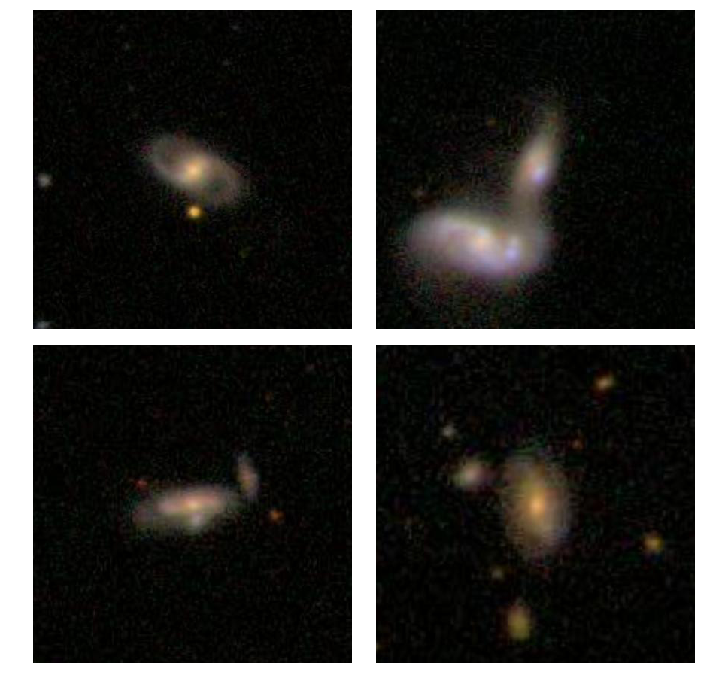

In [5]:
def im_grid(w, h, img_list):
    """
    Description:
    Create a grid of images of width "w" and heigh "h" using images in img_list
    """
    # Set size of total grid
    fig=plt.figure(figsize=(12, 12))
    # Set size between elements in the grid
    fig.subplots_adjust(hspace=0.05, wspace=0.05)
    columns = h
    rows = w
    # Iterate through the total number of grid elements.
    for i in range(1, columns*rows + 1):
        # If the image has been provided as a filepath, read it.
        try:
            img = plt.imread(img_list[i-1])
        # If the image has been provided as image data, assign it to a variable
        except:
            img = img_list[i-1]
        # Assign the image to a spot in the grid
        fig.add_subplot(rows, columns, i)
        plt.imshow(img)
        # Do not show axes.
        plt.axis('off')
    
    plt.show()
    return
im_grid(2,2, training_img_files[0:5])

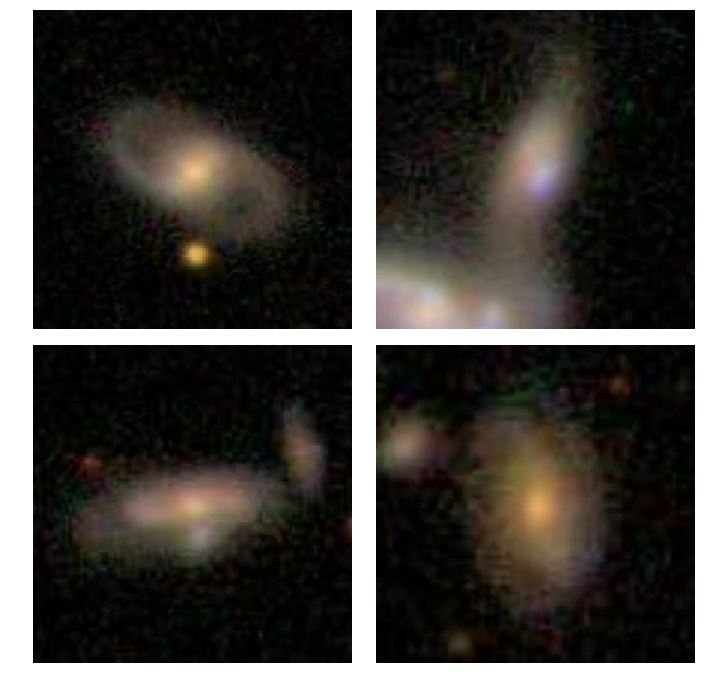

In [6]:
im_grid(2,2, scaled_sample_images[0:5])

In [7]:
from itertools import islice
class Batchifier:    
    """
    Class for creating training, testing, and validation batches.
    """
    def __init__(self, parent_path):    
        # Describe directory structure
        self.path = parent_path
        self.target_path = 'target_data/'
        self.training_path = parent_path + "train_images/"
        self.testing_path = parent_path + "test_images/"
        self.validation_path = parent_path + "validation_images/"
        
        
        def get_filepaths(directory):
            # Converts directory structures to lists of filepaths
            return [f for f in os.listdir(directory) if f[-4:] == '.jpg']
        
        # Convert each directory to a list of filepaths
        self.training_img_files = get_filepaths(self.training_path)
        self.testing_img_files = get_filepaths(self.testing_path)   
        self.validation_img_files = get_filepaths(self.validation_path)
         
        
        def get_targets(self, target_path):
            """
            Description: Separates target data from key values and returns a dictionary of target data.
            Inputs: Target data in a csv file.
            Outputs: A dictionary of target values with labels as keys and target data as values.
            """
            # Create dataframe from the name of the csv file in target_path
            targets_df = pd.read_csv(target_path + 'targets.csv')
            # Create empty dictionary for temporary storage of target data
            targets = {}
            # Iterate through the targets_df dataframe
            for idx, row in targets_df.iterrows():
                # Create a mask to select only the label data
                key_mask = row.index.isin(['GalaxyID'])
                # Convert the label data to a string to use as a dictionary key
                key = str(int(row['GalaxyID']))
                # Use the inverse of the key mask to select only the target data
                target_values = row[~key_mask]
                # Use the key to store the target values in a particular instance of the targets dictionary
                targets[key] = list(target_values.values)
            return targets
        
        # Use the get_targets function to assign target data dictionary to self.targets
        self.targets = get_targets(self, target_path)

    # Create an ID from the filename of each image
    def get_galaxyid(self,fname):
        return fname.replace(".jpg","").replace("data","")
        
    # Get the target data assigned to any particular label.
    def find_label(self, label):
        return self.targets[label]   

batch_object = Batchifier(data_path)

In [8]:
# Create generator that yields (current features X, current labels y)
def TrainingBatchGenerator(batch):
    while 1:
        for f in batch.training_img_files:
            # Crop image contained in "f".
            X_train = center_crop_images([batch.training_path + '/' + fname for fname in [f]], (212, 212, 3))
            # Get the ID (label) for this image file
            galaxyid_ = batch.get_galaxyid(f)
            # Get the target data associated with this ID
            y_train = np.array(batch.find_label(galaxyid_))
            # Ensure the target data is shaped appropriately to the number of classes
            y_train = np.reshape(y_train,(1,37))
            # Return formatted training and target data.
            yield (X_train, y_train)

def TestingBatchGenerator(batch):
    while 1:
        # Follows the exact same process as TrainingBatchGenerator, but using a different path
        for f in batch.testing_img_files:
            X_train = center_crop_images([batch.testing_path + '/' + fname for fname in [f]], (212, 212, 3))
            galaxyid_ = batch.get_galaxyid(f)
            y_train = np.array(batch.find_label(galaxyid_))
            y_train = np.reshape(y_train,(1,37))
            yield (X_train, y_train)
            
def ValidationBatchGenerator(batch):
    while 1:
        # Follows the exact same process as TrainingBatchGenerator, but using a different path
        for f in batch.validation_img_files:
            X_train = center_crop_images([batch.validation_path + '/' + fname for fname in [f]], (212, 212, 3))
            galaxyid_ = batch.get_galaxyid(f)
            y_train = np.array(batch.find_label(galaxyid_))
            y_train = np.reshape(y_train,(1,37))
            yield (X_train, y_train)

In [9]:
# Initialize a VGG model using pretrain imagenet weights, not including the top-most layers
vgg = VGG16(weights='imagenet', input_shape = (212,212,3), include_top=False)

In [10]:
#Adding custom top layers to allow training for this particular data
x = vgg.output
x = Flatten()(x)
x = Dense(1024, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(1024, activation="relu")(x)
# It is important to use "sigmoid" activation in this case, as probabilities for each class do not add to 1.
predictions = Dense(37, activation="sigmoid")(x)
model_final = Model(inputs = vgg.input, outputs = predictions)

In [11]:
# Set up optimizer
optimizer = Adam(lr=1e-5, beta_1=0.9, beta_2=0.999, epsilon=1e-8)

In [12]:
# Compile model
model_final.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mse'])

In [13]:
batch_size = 32
training_steps = int(len(batch_object.training_img_files)/batch_size)
validation_steps = int(len(batch_object.validation_img_files)/batch_size)

In [14]:
# Set directory to save best model using checkpoint callback, with {epoch:02d}-{val_loss:.4f} 
# naming the file accoring to the epoch with the lowest validation loss
modelpath = '../model/weights.{epoch:02d}-{val_loss:.4f}.hdf5'

# Set directory in which to store the 
logpath = '../log_181201/'

# Set up the early stopping call back. Because each epoch completes quickly, I have set it to a 
# high level of patience to allow for a large number of training epochs if wanted
earlystopping_callback = EarlyStopping(monitor='val_loss', patience=10)

# Set up checkpoint callback to save the model with the lowest validation loss
checkpoint_callback = ModelCheckpoint(modelpath, monitor='val_loss', verbose=0, 
                                      save_best_only=True, save_weights_only=False, 
                                      mode='auto', period=1)

#Set up the tensorboard callback to track model training in Tensorboard
tensorboard_callback = TensorBoard(log_dir=logpath, histogram_freq=0, batch_size=batch_size, 
                            write_graph=True, update_freq='epoch')

In [15]:
"""
Fit model to training data, checking against validation data for loss.
Include callbacks for early stopping, checkpoints, and tensorboard.
Because training time is relatively short with a decent GPU, a large number of 
"""
hist = model_final.fit_generator(TrainingBatchGenerator(batch_object), 
                                 steps_per_epoch = training_steps,
                                 validation_data = ValidationBatchGenerator(batch_object), 
                                 validation_steps = validation_steps,
                                 epochs = 50,
                                 callbacks = [earlystopping_callback,
                                              checkpoint_callback, 
                                              tensorboard_callback])

Epoch 1/50


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


1289/1289 [==============================] - 156s 121ms/step - loss: 0.0371 - mean_squared_error: 0.0371 - val_loss: 0.0229 - val_mean_squared_error: 0.0229
Epoch 2/50
1289/1289 [==============================] - 151s 117ms/step - loss: 0.0235 - mean_squared_error: 0.0235 - val_loss: 0.0176 - val_mean_squared_error: 0.0176
Epoch 3/50
1289/1289 [==============================] - 151s 117ms/step - loss: 0.0191 - mean_squared_error: 0.0191 - val_loss: 0.0149 - val_mean_squared_error: 0.0149
Epoch 4/50
1289/1289 [==============================] - 151s 117ms/step - loss: 0.0172 - mean_squared_error: 0.0172 - val_loss: 0.0167 - val_mean_squared_error: 0.0167
Epoch 5/50
1289/1289 [==============================] - 151s 117ms/step - loss: 0.0168 - mean_squared_error: 0.0168 - val_loss: 0.0145 - val_mean_squared_error: 0.0145
Epoch 6/50
1289/1289 [==============================] - 151s 117ms/step - loss: 0.0164 - mean_squared_error: 0.0164 - val_loss: 0.0137 - val_mean_squared_error: 0.0137
Epo

In [16]:
model_final.evaluate_generator(TestingBatchGenerator(batch_object), 
                         steps = len(batch_object.testing_img_files)/batch_size)

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[0.009372157611043644, 0.009372157611043644]

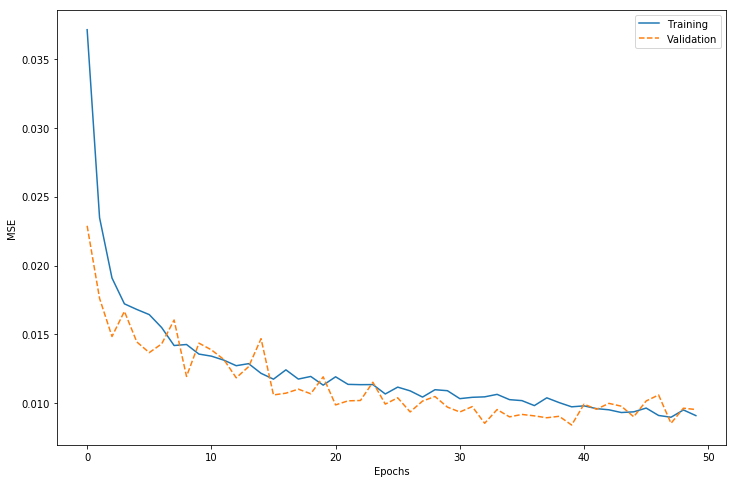

In [17]:
plt.figure(figsize=(12,8))
plt.plot(hist.epoch,hist.history['loss'],label='Training')
plt.plot(hist.epoch,hist.history['val_loss'],label='Validation',linestyle='--')
plt.xlabel("Epochs")
plt.ylabel("MSE")
plt.legend()
plt.show()

In [19]:
predictions = model_final.predict_generator(TestingBatchGenerator(batch_object), 
                                      steps = len(batch_object.testing_img_files))

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [22]:
test_predictions_dict = {}
test_targets_dict = {}
for idx, fn in enumerate(batch_object.testing_img_files):
    label = batch_object.get_galaxyid(fn)
    pred_data = predictions[idx]
    targ_data = batch_object.find_label(label)
    test_predictions_dict[label] = pred_data
    test_targets_dict[label] = targ_data

In [36]:
df_test_targets=pd.DataFrame(test_targets_dict).T

In [40]:
df_test_predictions=pd.DataFrame(test_predictions_dict).T

In [47]:
df_test_targets.to_csv('test_targets.csv')

In [48]:
df_test_predictions.to_csv('test_predictions.csv')